# Logistic Regression to Identify Handwritten Digits
In this notebook we will use logistic regression to identify handwritten objects, the dataset to be used is the famous MNIST developed by Yan Le Cunn and is used as a benchmark to test performance of classification algorithms. The dataset and its description can be downloaded [here](http://yann.lecun.com/exdb/mnist/)

In [1]:
from __future__ import absolute_import, division, print_function
import os
import platform
import numpy as np
import tensorflow as tf

## Dataset Description
This dataset consist of 28x28 px grayscale images, this images are vectorized, e.g., each row of a matrix in conacatenated so that the image can be represented as a 784 dimensional vector. The original dataset contains digits from 0 to 9, then it will be necessary to import only the samples labelled with 0 or 1.

## Importing Training Dataset
The files are stored in a compressed format, and we have a different file for the features (784) and the labels (0-1).

In [2]:
def read_mnist_images(filename):
    import struct
    import gzip
    with gzip.open(filename) as f:
        buf = f.read(16)
        magic, n_items, xsize, ysize = struct.unpack(">iiii", buf)
        assert magic == 2051
        n_features = xsize*ysize
        data = np.zeros((n_items, n_features), dtype=np.uint8)
        for i in range(n_items):
            buf = f.read(n_features)
            x = struct.unpack("B"*n_features, buf)
            data[i, :] = x
    return data

def read_mnist_labels(filename):
    import struct
    import gzip
    with gzip.open(filename) as f:
        buf = f.read(8)
        magic, n_items = struct.unpack(">ii", buf)
        assert magic == 2049
        data = np.zeros(n_items, dtype=np.uint8)
        buf = f.read(n_items)
        data[:] = struct.unpack("B"*n_items, buf)
    return data

mnist_features = read_mnist_images('train-images-idx3-ubyte.gz')
mnist_labels = read_mnist_labels('train-labels-idx1-ubyte.gz')
test_mnist_features = read_mnist_images('t10k-images-idx3-ubyte.gz')
test_mnist_labels = read_mnist_labels('t10k-labels-idx1-ubyte.gz')

## Displaying some sample data

[3]


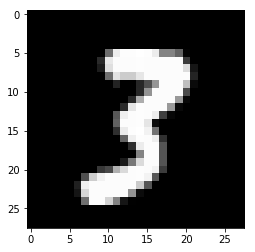

In [11]:
import matplotlib.pyplot as plt
img_num = np.random.randint(mnist_features.shape[0], size=1)
image_test = mnist_features[img_num].reshape((28,28))
imgplot = plt.imshow(image_test, cmap="gray")
print(mnist_labels[img_num])
plt.show()

In [12]:
zero_one_indices = (mnist_labels == 1) + (mnist_labels == 0)
test_zero_one_indices = (test_mnist_labels == 1) + (test_mnist_labels == 0)
mnist_labels_binary = mnist_labels[zero_one_indices]
mnist_labels_binary = mnist_labels_binary.reshape((mnist_labels_binary.shape[0],1))
mnist_features_binary = mnist_features[zero_one_indices]
test_mnist_labels_binary = mnist_labels[test_zero_one_indices]
test_mnist_labels_binary = test_mnist_labels_binary.reshape((test_mnist_labels_binary.shape[0],1))
test_mnist_features_binary = mnist_features[test_zero_one_indices]
print(mnist_labels_binary.shape, mnist_features_binary.shape)
print(test_mnist_labels_binary.shape, test_mnist_features_binary.shape)

(12665, 1) (12665, 784)
(2115, 1) (2115, 784)


/Users/david/PythonEnv/opecv_tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 60000 but corresponding boolean dimension is 10000
/Users/david/PythonEnv/opecv_tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 60000 but corresponding boolean dimension is 10000


[[0]]


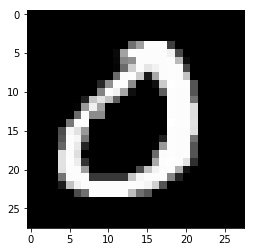

In [23]:
img_num = np.random.randint(mnist_features_binary.shape[0], size=1)
image_test = mnist_features_binary[img_num].reshape((28,28))
imgplot = plt.imshow(image_test,cmap="gray")
print(mnist_labels_binary[img_num])
plt.show()

Add a column of ones to the features to act as an intercept term

In [24]:
mnist_features_binary = np.c_[np.ones(mnist_features_binary.shape[0]), mnist_features_binary]
test_mnist_features_binary = np.c_[np.ones(test_mnist_features_binary.shape[0]), test_mnist_features_binary]

## Training Parameters

In [25]:
learning_rate = 0.001
training_epochs = 50
cost_history = np.empty(shape=[1],dtype=float)
display_step = 5

## Variables and placeholders

In [26]:
n_dim = mnist_features_binary.shape[1]
x = tf.placeholder(tf.float32, shape=mnist_features_binary.shape, name="x") # MNIST data image 28x28 px
y = tf.placeholder(tf.float32, shape=mnist_labels_binary.shape, name="y") # Recognize 2 types of digits 0 or 1
W = tf.Variable(tf.zeros([n_dim,1]))

## Define the model

In [27]:
pred = tf.matmul(x,W)
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=pred))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()

## Training Time

In [28]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(optimizer, feed_dict={x:mnist_features_binary,y:mnist_labels_binary})
    c = sess.run(cost, feed_dict={x:mnist_features_binary,y:mnist_labels_binary})
    cost_history = np.append(cost_history, c)
    y_pred = sess.run(pred, feed_dict={x:mnist_features_binary})
    if (epoch+1) % display_step == 0:
        print("Epoch:",'%04d' % (epoch+1), "cost=", c)
print ("Optimization Finished!")

Epoch: 0005 cost= 0.460649
Epoch: 0010 cost= 0.313321
Epoch: 0015 cost= 0.262155
Epoch: 0020 cost= 0.237857
Epoch: 0025 cost= 0.222398
Epoch: 0030 cost= 0.209262
Epoch: 0035 cost= 0.197902
Epoch: 0040 cost= 0.186962
Epoch: 0045 cost= 0.176531
Epoch: 0050 cost= 0.166579
Optimization Finished!


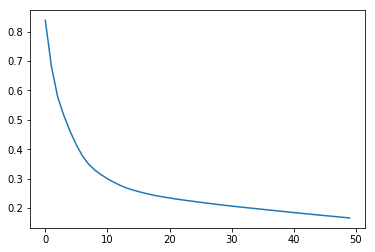

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(training_epochs), cost_history[1:])
plt.show()

In [30]:
predictions = sess.run(tf.nn.sigmoid(tf.matmul(x,W)), feed_dict={x:mnist_features_binary})
correct = tf.equal(predictions,mnist_labels_binary)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
print(sess.run(accuracy)*100,"%")

99.5341479778 %


In [34]:
print(mnist_features_binary[:,1:].shape)

(12665, 784)


[[ 1.]]


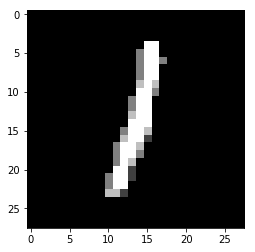

In [38]:
img_num = np.random.randint(mnist_features_binary.shape[0], size=1)
image_test = mnist_features_binary[img_num,1:].reshape((28,28))
imgplot = plt.imshow(image_test,cmap="gray")
print(predictions[img_num])
plt.show()

## Testing

In [82]:
x_test = tf.placeholder(tf.float32, shape=test_mnist_features_binary.shape, name="x_test")
predictions = sess.run(tf.nn.sigmoid(tf.matmul(x_test,W)), feed_dict={x_test:test_mnist_features_binary})
correct = tf.equal(predictions,test_mnist_labels_binary)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
print(sess.run(accuracy)*100,"%")

20.614656806 %
